In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
import os
import urllib
import urllib.request
import gzip
import struct
import time

#import mnist dataset
from keras.datasets import mnist

#classification on reconstructed data
from sklearn.neighbors import KNeighborsClassifier 

import seaborn as sns

In [2]:
def to_one_hot(labels, num_classes=10):
        return np.eye(num_classes)[labels]

In [3]:
def sigmoid_function(signal, derivative=False):
    if derivative:
        return np.multiply(signal, 1.0 - signal)
    else:
        return 1.0 / (1.0 + np.exp(-signal))

In [4]:
def subtract_err(outputs, targets):
    res = outputs - targets
    return res

In [5]:
class LinearLayer:
    def __init__(self, name, n_in, n_out, activation=sigmoid_function):
        self.name = name
        self.activation = activation
        self.result = []

        self.weights = 2 * np.random.random((n_in, n_out)) - 1
        self.biases = np.zeros(n_out)

    def get_output(self, x):
        result = self.activation(x.dot(self.weights) + self.biases)
        self.result = result
        return result

In [6]:
class SparseLayer(LinearLayer):
    def __init__(self, name, n_in, n_out, activation=sigmoid_function, num_k_sparse=10):
        LinearLayer.__init__(self, name, n_in, n_out, activation)
        self.num_k_sparse = num_k_sparse

    def get_output(self, x):
        result = self.activation(x.dot(self.weights) + self.biases)

        k = self.num_k_sparse
        if k < result.shape[1]:
            for raw in result:
                indices = np.argpartition(raw, -k)[-k:]
                mask = np.ones(raw.shape, dtype=bool)
                mask[indices] = False
                raw[mask] = 0

        self.result = result
        return result

In [7]:
def costAE(self, theta, visible_input):
    W1, W2, b1, b2 = self.unpack_theta(theta)

    hidden_layer = self.sigmoid(np.dot(W1, visible_input) + b1)
    output_layer = self.sigmoid(np.dot(W2, hidden_layer) + b2)
    m = visible_input.shape[1] 

    error = -(visible_input - output_layer)
    sum_sq_error =  0.5 * np.sum(error * error, axis = 0)
    avg_sum_sq_error = np.mean(sum_sq_error)
    reg_cost =  self.lambda_ * (np.sum(W1 * W1) + np.sum(W2 * W2)) / 2.0
    rho_bar = np.mean(hidden_layer, axis=1)
    KL_div = np.sum(self.rho * np.log(self.rho / rho_bar) + 
                    (1 - self.rho) * np.log((1-self.rho) / (1- rho_bar)))        
    cost = avg_sum_sq_error + reg_cost + self.beta * KL_div

    # Back propagation
    KL_div_grad = self.beta * (- self.rho / rho_bar + (1 - self.rho) / 
                                (1 - rho_bar))

    del_3 = error * output_layer * (1.0 - output_layer)
    del_2 = np.transpose(W2).dot(del_3) + KL_div_grad[:, np.newaxis]
    del_2 *= hidden_layer * (1 - hidden_layer)

    W1_grad = del_2.dot(visible_input.transpose()) / m
    W2_grad = del_3.dot(hidden_layer.transpose()) / m
    b1_grad = del_2
    b2_grad = del_3

    W1_grad += self.lambda_ * W1 
    W2_grad += self.lambda_ * W2
    b1_grad = b1_grad.mean(axis = 1)
    b2_grad = b2_grad.mean(axis = 1)

    theta_grad = np.concatenate((W1_grad.flatten(), W2_grad.flatten(), 
                                 b1_grad.flatten(), b2_grad.flatten()))        
    return [cost, theta_grad]

In [8]:
class FCNeuralNet:
    def __init__(self, layers, cost_func=subtract_err):
        self.layers = layers
        self.cost_func = cost_func

    def print_network(self):
        print("network:")
        for layer in self.layers:
            print("layer - %s: weights: %s" % (layer.name, layer.weights.shape))

    def train(self, x, y, learning_rate=0.01, epochs=10000,batch_size=256):
        start_time = time.time()

        for k in range(epochs):
            rand_indices = np.random.randint(x.shape[0], size=batch_size)
            batch_x = x[rand_indices]
            batch_y = y[rand_indices]

            results = self.feed_forward(batch_x)

            error = self.cost_func(results[-1], batch_y)
            
            
            if (k+1)%100 == 0:
                loss = np.mean(np.abs(error))
                print(f"epoch {k + 1}: loss {loss}")
            
            deltas = self.back_propagate(results, error)
            self.update_weights(results, deltas, learning_rate)

        end_time = time.time() - start_time
        elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time))
        print("training complete, elapsed time:", elapsed_time)

    def feed_forward(self, x):
        results = [x]
        for i in range(len(self.layers)):
            output_result = self.layers[i].get_output(results[i])
            results.append(output_result)
        return results

    def back_propagate(self, results, error):
        last_layer = self.layers[-1]
        deltas = [error * last_layer.activation(results[-1], derivative=True)]
        for i in range(len(results) - 2, 0, -1):
            layer = self.layers[i]
            delta = deltas[-1].dot(layer.weights.T) * layer.activation(results[i], derivative=True)
            deltas.append(delta)

        deltas.reverse()
        return deltas

    def update_weights(self, results, deltas, learning_rate):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer_result = results[i]
            delta = deltas[i]
            layer.weights -= learning_rate * layer_result.T.dot(delta)
            # layer.biases += delta

    def predict(self, x):
        return self.feed_forward(x)[-1]

    def accuracy(self, x_data, y_labels):
        predictions = np.argmax(self.predict(x_data), axis=1)
        labels = np.argmax(y_labels, axis=1)
        accuracy = np.mean(predictions == labels)
        return accuracy * 100

In [9]:
def add_plot_images(images, cols=15, img_size=14, title=None):
    n_images = len(images)    
    fig = plt.figure(figsize=(30, 5))
    plt.title(title, fontsize=24)
    plt.axis('off')
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(img)

In [10]:
(train_img, train_lbl), (test_img, test_lbl) = mnist.load_data()

In [11]:
train_lbl = to_one_hot(train_lbl)
test_lbl = to_one_hot(test_lbl)

In [12]:
img_size = 28
num_hidden = 200
k = 10
learning_rate = 0.01
epochs = 2000
batch_size = 256
num_test_examples = 15

x_data = train_img.reshape(-1, img_size * img_size) / float(256)
test_data = test_img.reshape(-1, img_size * img_size) / float(256)

In [13]:
layers = [
    SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                activation=sigmoid_function, num_k_sparse=k),
    SparseLayer(name="hidden 2", n_in=num_hidden, n_out=100,
                activation=sigmoid_function, num_k_sparse=k),
    LinearLayer(name="output", n_in=100, n_out=x_data.shape[1], activation=sigmoid_function)
]
global nn
nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
nn.print_network()

network:
layer - hidden 1: weights: (784, 200)
layer - hidden 2: weights: (200, 100)
layer - output: weights: (100, 784)


In [14]:
nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)

epoch 100: loss 0.12941367625314645
epoch 200: loss 0.12360953680936991
epoch 300: loss 0.11855259030166714
epoch 400: loss 0.1164645796969695
epoch 500: loss 0.11182418527809392
epoch 600: loss 0.10947288382204368
epoch 700: loss 0.10591237883171195
epoch 800: loss 0.09928394023592894
epoch 900: loss 0.10561610310274756
epoch 1000: loss 0.10347112067214444
epoch 1100: loss 0.10249880083717725
epoch 1200: loss 0.102285123915468
epoch 1300: loss 0.09982351970437166
epoch 1400: loss 0.09986798023608524
epoch 1500: loss 0.09849880332330395
epoch 1600: loss 0.09667761884552437
epoch 1700: loss 0.09833550758211085
epoch 1800: loss 0.09635211341365153
epoch 1900: loss 0.09719369939050941
epoch 2000: loss 0.09478429662034056
training complete, elapsed time: 00:02:03


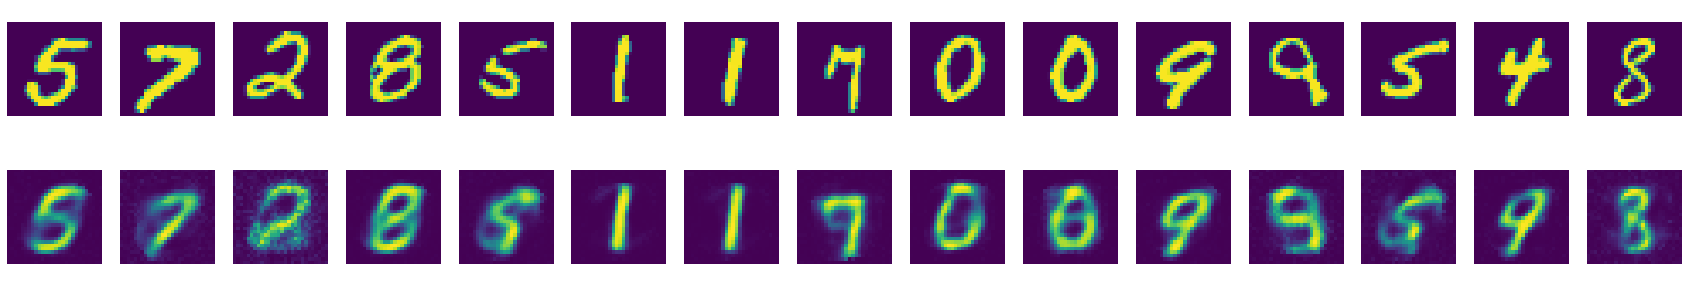

In [15]:
n = num_test_examples

test_samples = test_data[np.random.randint(test_data.shape[0], size=15)]
encode_samples = nn.layers[0].weights.T
output_samples = nn.predict(test_samples)

global hidden_layer_op
hidden_layer_op = nn.feed_forward(test_samples)
global img_input
global img_output
global img_encode

img_input = test_samples.reshape(-1, img_size, img_size)
img_encode = encode_samples.reshape(-1, img_size, img_size)
img_output = output_samples.reshape(-1, img_size, img_size)

global all_images
all_images = np.concatenate((img_input, img_output))

add_plot_images(all_images, cols=15, img_size=img_size)
plt.show()

In [16]:
x_data = train_img.reshape(-1, 28 * 28) / float(256) 
x_data_re = nn.predict(x_data)  
y_data = train_lbl 

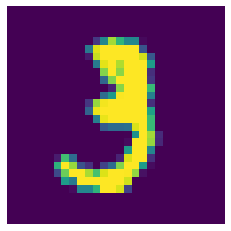

In [17]:
plt.axis('off')
plt.imshow(x_data[10].reshape((28,28)))

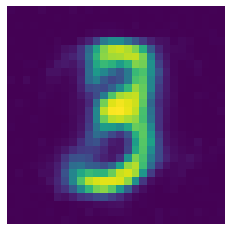

In [18]:
plt.axis('off')
plt.imshow(x_data_re[10].reshape((28,28)))

In [19]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_data[500:], y_data[500:])
pred_op = neigh.predict(x_data[:500])
acco = np.all((pred_op == y_data[:500]), axis=1).sum() / pred_op.shape[0] * 100
print ('Accuracy on original: ', acco)

Accuracy on original:  96.2


In [20]:
neigh.fit(x_data_re[500:], y_data[500:])                #classification on reconstructed data
pred_op = neigh.predict(x_data[:500])
accr = np.all((pred_op == y_data[:500]), axis=1).sum() / pred_op.shape[0] * 100
print ('Accuracy on reconstruted: ', accr)

Accuracy on reconstruted:  89.0


In [21]:
cm = confusion_matrix(np.argmax(y_data[:500], axis=1), np.argmax(pred_op, axis=1))
print(cm)

[[50  0  0  0  0  0  0  0  0  0]
 [ 4 61  0  0  0  0  1  0  0  0]
 [ 3  1 46  0  0  0  0  2  0  0]
 [ 5  0  0 44  0  0  0  0  1  0]
 [ 2  0  0  0 48  0  0  0  0  2]
 [ 4  0  0  1  0 33  0  0  1  0]
 [ 1  0  0  0  0  0 44  0  0  0]
 [ 3  2  0  0  0  0  0 47  0  0]
 [ 3  0  0  2  0  2  0  0 32  0]
 [ 3  0  0  1  6  0  0  2  1 42]]


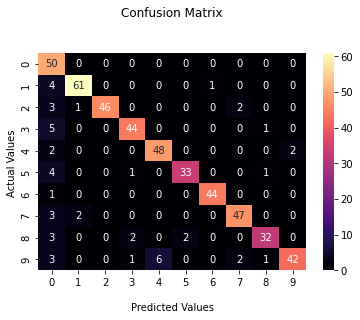

In [22]:
ax = sns.heatmap(cm, annot=True, cmap = plt.cm.magma)
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()